In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import os
from keras import backend as K
from sklearn.metrics import mean_squared_error
import math
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from keras.utils import to_categorical,Sequence

C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
trainDF = pd.read_csv("./input/avito-demand-prediction/train.csv")

trainDF.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [3]:
# Convert categorical variables to one-hot vectors.  
trainDF["category_name"] = pd.Categorical(trainDF["category_name"]).codes
trainDF["city"] = pd.Categorical(trainDF["city"]).codes
trainDF["region"] = pd.Categorical(trainDF["region"]).codes
trainDF["parent_category_name"] = pd.Categorical(trainDF["parent_category_name"]).codes
trainDF["user_type"] = pd.Categorical(trainDF["user_type"]).codes

trainDF.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,19,460,4,42,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,1,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,17,1300,2,22,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,1,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,16,1276,0,2,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,1,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,21,940,4,42,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,0,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,4,317,6,0,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,1,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [4]:
def percentileOneHot(dealProb,nBuckets=10):
    val = math.floor((dealProb*nBuckets))
    if dealProb == 1: 
        val = nBuckets-1
        
    return val,to_categorical(val , num_classes=nBuckets)

percentileRes = trainDF["deal_probability"].map(percentileOneHot) 
trainDF = trainDF.assign(percentileClassID = percentileRes.apply(lambda x: x[0]), percentileClass = percentileRes.apply(lambda x: x[1]))

In [5]:
# Create a training and validation set. 
trainDF = trainDF.sample(frac=1)

nItems = trainDF.shape[0]
nValidation = int(nItems * 0.2)

validation = trainDF[0:nValidation]
train      = trainDF[nValidation:]

In [6]:
print(train.shape)
print(validation.shape)

(1202740, 20)
(300684, 20)


In [132]:
feats = ["price","region","city","category_name","parent_category_name",
         "user_type","title","description","image_top_1","item_seq_number","activation_date","deal_probability"]

max_features = 20000
maxlen = 200
descTokenizer = Tokenizer(num_words=max_features)

def preprocessDat(df):
    select = df.dropna()
    select = select.assign(descLen = select["description"].map(len))
    select = select.assign(titleLen = select["title"].map(len))
    select["activation_date"] = pd.to_datetime(select["activation_date"])
    select["activation_date"] = select["activation_date"].map(lambda x: x.dayofweek)
    
    return select

# Training Preprocessing 
select_train = preprocessDat(train[feats])
#descTokenizer.fit_on_texts(select_train["description"]) 
#select_train_desc = pad_sequences(descTokenizer.texts_to_sequences(select_train["description"]),maxlen = maxlen )
select_train = select_train.drop(["description","title"],axis=1)

# Validation Preprocesing
select_val = preprocessDat(validation[feats])
#select_val_desc = pad_sequences(descTokenizer.texts_to_sequences(select_val["description"]),maxlen = maxlen )
select_val = select_val.drop(["description","title"],axis=1)

scaler = preprocessing.RobustScaler().fit(select_train.drop("deal_probability",axis=1))
select_train_scaled = scaler.transform(select_train.drop("deal_probability",axis=1))
select_val_scaled   = scaler.transform(select_val.drop("deal_probability",axis=1))

select_train.head()

,price,region,city,category_name,parent_category_name,user_type,image_top_1,item_seq_number,activation_date,deal_probability,descLen,titleLen
962875,8500.0,9,723,22,2,0,1530.0,68,4,0.00000,142,15
31739,3000.0,1,1589,41,0,1,2936.0,39,0,0.27219,130,13
213751,1000.0,19,460,29,4,1,505.0,24,0,0.00000,80,17
391324,5500.0,21,585,22,2,1,1490.0,12,5,0.00000,50,6
1499804,500.0,5,329,10,4,1,658.0,20,1,0.00000,77,35


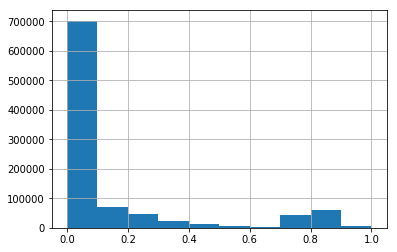

In [127]:
select_train["deal_probability"].hist()
plt.show()

In [133]:
class EvenClassDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df, categoricalColumn,targetCol, batch_size=10):
        'Initialization'
        self.batch_size = batch_size
        self.targetCol = targetCol
        self.classes = list(np.sort(df[categoricalColumn].unique()))
        self.categories = list(map(lambda x: df[df[categoricalColumn] == x].drop(categoricalColumn,axis=1),self.classes))
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return 1000

    def __getitem__(self, index):
        'Generate one batch of data'
        resultsX  = []
        dealProbs = []
        
        for cat in self.categories:
            sample = cat.sample(self.batch_size)
            resultsX.append(scaler.transform(sample.drop(self.targetCol,axis=1)))
            dealProbs.append(np.vstack(sample[self.targetCol]))
            
        X = np.vstack(resultsX)
        y = np.vstack(dealProbs)
        return X, y

def percentileOneHot(dealProb,nBuckets=10):
    val = math.floor((dealProb*nBuckets))
    if dealProb == 1: 
        val = nBuckets-1
    
    if val == 0:
        pass
    elif val in [2,3,4,5,6]:
        val = 1
    else:
        val = 2
    
    return val,to_categorical(val , num_classes=nBuckets)

percentileRes = select_train["deal_probability"].map(percentileOneHot) 
select_train_gen = select_train.assign(percentileClassID = percentileRes.apply(lambda x: x[0]))

balancedBatch = EvenClassDataGenerator(select_train_gen,"percentileClassID","deal_probability",50)

# NN

In [134]:
from keras.layers import Dense, Input,BatchNormalization,Dropout
from keras.models import Model
from keras import backend

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

inp1 = Input(shape=(len(feats)-1, ))
x = Dense(100,activation="sigmoid")(inp1)
x = Dense(100,activation="sigmoid")(x)
x = Dense(100,activation="sigmoid")(x)
x = Dense(100,activation="sigmoid")(x)
x = Dense(100,activation="sigmoid")(x)
x = Dense(100,activation="sigmoid")(x)
x = Dense(100,activation="sigmoid")(x)
x = Dense(1,activation="sigmoid")(x)

model = Model(inp1,x)
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=[rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 11)                0         
_________________________________________________________________
dense_155 (Dense)            (None, 100)               1200      
_________________________________________________________________
dense_156 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_157 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_158 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_159 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_160 (Dense)            (None, 100)               10100     
__________

In [135]:
model.fit_generator(balancedBatch,steps_per_epoch=1000,epochs=500,verbose=1)

Epoch 1/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5925 - rmse: 0.2394
Epoch 2/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5835 - rmse: 0.2325
Epoch 3/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5836 - rmse: 0.2327
Epoch 4/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5830 - rmse: 0.2317
Epoch 5/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5835 - rmse: 0.2324
Epoch 6/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5819 - rmse: 0.23100s - loss: 0.581
Epoch 7/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5829 - rmse: 0.2318
Epoch 8/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5825 - rmse: 0.2317
Epoch 9/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5813 - rmse: 0.2307
Epoch 10/500
1000/1000 [==============================] - 25s 25ms/step - l

1000/1000 [==============================] - 25s 25ms/step - loss: 0.5689 - rmse: 0.2215
Epoch 77/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5682 - rmse: 0.2208
Epoch 78/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5691 - rmse: 0.22110s - loss: 0
Epoch 79/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5688 - rmse: 0.2210
Epoch 80/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5678 - rmse: 0.22070s
Epoch 81/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5682 - rmse: 0.2204
Epoch 82/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5678 - rmse: 0.2207
Epoch 83/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5681 - rmse: 0.2207
Epoch 84/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5688 - rmse: 0.2213
Epoch 85/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0

1000/1000 [==============================] - 25s 25ms/step - loss: 0.5655 - rmse: 0.2187
Epoch 154/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5652 - rmse: 0.2185
Epoch 155/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5655 - rmse: 0.2188
Epoch 156/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5657 - rmse: 0.2188
Epoch 157/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5653 - rmse: 0.2189
Epoch 158/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5665 - rmse: 0.2196
Epoch 159/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5655 - rmse: 0.21860s - loss: 0.5656 - rmse:  - ETA: 0s - loss:
Epoch 160/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5647 - rmse: 0.2181
Epoch 161/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5657 - rmse: 0.2187
Epoch 162/500
1000/1000 [==================

1000/1000 [==============================] - 25s 25ms/step - loss: 0.5644 - rmse: 0.2178: 30s - loss: 0.5626 - rmse - ETA: 26s - loss: 0 - ETA: 23s - loss: - -  - ETA: 8s - loss: 0.5640 - rmse: 
Epoch 213/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5639 - rmse: 0.2175
Epoch 214/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5640 - rmse: 0.2178
Epoch 215/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5646 - rmse: 0.2178
Epoch 216/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5638 - rmse: 0.21731s - loss: 0.5638 - rmse: 0.21 - ETA: 1s - loss: 0.5638  - ETA: 0s - loss: 0.5 - ETA: 0s - loss: 0.5638 - rmse: 
Epoch 217/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5635 - rmse: 0.2171
Epoch 218/500
1000/1000 [==============================] - 25s 25ms/step - loss: 0.5634 - rmse: 0.21691s - loss: 0.5635 - rmse:  - ETA: 1s - - ETA: 0s - loss: 0.5634 - rm
Epoch 2

KeyboardInterrupt: 

In [136]:
pred = model.predict(select_val_scaled)
true = select_val["deal_probability"]
math.sqrt(mean_squared_error(true,pred))

0.26803568754821827

In [17]:
train_mean = select_train["deal_probability"].mean()
pred = np.full(select_val["deal_probability"].shape,train_mean )
true = select_val["deal_probability"]
math.sqrt(mean_squared_error(true,pred))

0.2627653092426415

In [16]:
select_val["deal_probability"].shape

(261417,)